# Drone Image Segmentation
----

In this notebook, I will be decribing the basics of Image Segmentation and the use of 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import cv2


from glob import glob
import os

2023-06-09 15:43:06.537321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [2]:
img_folder = './semantic_drone_dataset/images/'
mask_folder = './semantic_drone_dataset/label_images/'

In [3]:
img_files = np.sort(os.listdir(img_folder))
mask_files = np.sort(os.listdir(mask_folder))

In [5]:
def create_image_array(path, file_names: list):
    images = []
    for file in file_names:
        img = cv2.imread(path+file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299), interpolation = cv2.INTER_NEAREST )
        images.append(img)
        
    return images

In [6]:
images = create_image_array(img_folder, img_files)
masks = create_image_array(mask_folder, mask_files)

## Visualizing Data

In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

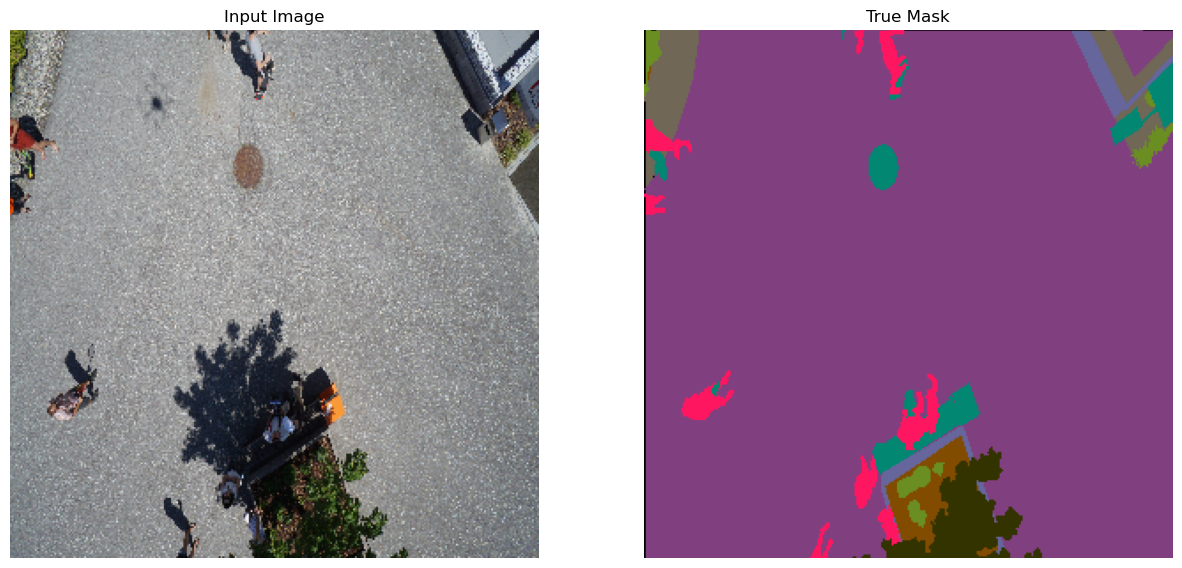

In [8]:
display([images[0], masks[0]])

## Preprocessing Data

In [9]:
color_map = pd.read_csv('./semantic_drone_dataset/class_dict.csv')
dummy_color_map = pd.get_dummies(color_map, columns = ['name'], prefix='', prefix_sep='')
cm = color_map.iloc[:, 1:].T.to_dict()
cm_id = {tuple(v.values()): k for k, v in cm.items()}

def mask_classes(mask):
    shape = list(mask.shape[:2]) + [1]
    mask_class = np.zeros(shape, dtype=int)
    sub = lambda x: cm_id[tuple(x)]
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            mask_class[x,y,0] = sub(mask[x,y,:])
    return mask_class

In [10]:
cm_rgb = {int(k): tuple(v.values()) for k, v in cm.items()}

def mask_rgb(mask):
    shape = list(mask.shape[:2]) + [3]
    mask_class = np.zeros(shape, dtype=int)
    sub = lambda x: cm_rgb[int(x)]
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            mask_class[x,y,:] = sub(mask[x,y,0])
    return mask_class

In [11]:
masks_w_class = list(map(mask_classes, masks))

## Saving Data

In [12]:
img_save_folder = './semantic_drone_dataset/processed/images/'
mask_save_folder = './semantic_drone_dataset/processed/label_images/'

In [13]:
def save_image_array(path, images):
    for i, img in enumerate(images):
        file = f"{i:03d}" + '.png'
        cv2.imwrite(path+file, img)
    return

In [14]:
save_image_array(img_save_folder, images)

In [15]:
save_image_array(mask_save_folder, masks_w_class)